In [778]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm
# import timeit
from scipy.integrate import odeint
from scipy import stats
from sklearn.manifold import MDS
from matplotlib.ticker import FormatStrFormatter
import modelSystems as ms
from EDMtoolkit import *
from modelSystems import *

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def MDStimescaleDecomp(Xr, lags=3, window_size=0.2):
    X, _ = delayEmbed(Xr, 1, lags, 1)
    
    n = X.shape[0]
    
    distance_matrix = distanceMatrix(X)

    similarity_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            similarity_matrix[i,j] = dynamicSimilarity(distance_matrix, i, j, window_size=window_size)
    print(f"{i},{j}:{similarity_matrix[i,j]}")
    
    similarity_matrix = standardize(similarity_matrix)
    
    fig, ax = plt.subplots(1)
    ax.imshow(similarity_matrix)
    plt.show()
    
    embedding = MDS(dissimilarity="precomputed")
    X_transformed = embedding.fit_transform(similarity_matrix)
    
    return X_transformed
    
"""
def dynamicSimilarity(distance_matrix, t1, t2, window_size=0.2):
    n = distance_matrix.shape[0]
    n_neighbors = 3
    
    win_radius = int(n * window_size)
    
    U = max(0, t1-win_radius)
    D = min(n, t1+win_radius)
    L = max(0, t2-win_radius)
    R = min(n, t2+win_radius)
    
    window = distance_matrix[U:D, L:R]

    distance = np.mean(np.exp(-window))
    
    return distance

    dynamic_similarity = 0
    for x1 in window1:
        neighbors = nearestNeighbors(x1, window2, n_neighbors)
        for neighbor in neighbors:
            dynamic_similarity += la.norm(neighbor-x1)**2
    
    return dynamic_similarity / (n*n_neighbors)
    
"""

"""
def driverVdelta(resolution):
    # Final data will be
    # Nonstat Rate(0,1)|thetaNS|deltaNS|errNS(l1o)|errNS(seq)|lagNS|dofNS|thetaS|errS(l1o)|errS(seq)|lagS|dofS
    
    table = np.zeros((resolution, 12))
    
    x0 = np.array([0.1,0.4,9])
    for r in range(resolution):
        rate = float(r)/resolution
        b1 = lambda t: 2.5 + rate * 4 * t / end
        
        Xr = standardize(generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime))[:,0,None]

        predictionHorizon = 1
        lagStep = 1
        maxLags = 6
        
        plotTS(Xr)
        
        thetaNS, deltaNS, errNS, lagsNS, thetaS, errS, lagsS = optimizationSuite(Xr, tr, predictionHorizon, maxLags, lagStep)
        
        Xn, Yn, txn = delayEmbed(Xr, predictionHorizon, lagsNS, lagStep, t=t)
        dofNS = dofestimation(Xn, Yn, txn, thetaNS, deltaNS)

        Xs, Ys, txs = delayEmbed(Xr, predictionHorizon, lagsS, lagStep, t=t)
        dofS = dofestimation(Xs, Ys, txs, thetaNS, 0)
        
        MSENS, sequentialNS = sequential(Xn, Yn, txn, thetaNS, deltaNS, returnSeries=True)
        MSES, sequentialS = sequential(Xs, Ys, txs, thetaS, 0, returnSeries=True)
        
        stinky = np.array([rate,thetaNS,deltaNS,errNS,MSENS,lagsNS,dofNS,thetaS,errS,MSES,lagsS,dofS])
        for pp in range(12):
            table[r,pp] = stinky[pp]
            
        AkaikeTest(errNS, errS, dofNS, dofS, Xr.shape[0])
        
    return table
"""   

"\ndef driverVdelta(resolution):\n    # Final data will be\n    # Nonstat Rate(0,1)|thetaNS|deltaNS|errNS(l1o)|errNS(seq)|lagNS|dofNS|thetaS|errS(l1o)|errS(seq)|lagS|dofS\n    \n    table = np.zeros((resolution, 12))\n    \n    x0 = np.array([0.1,0.4,9])\n    for r in range(resolution):\n        rate = float(r)/resolution\n        b1 = lambda t: 2.5 + rate * 4 * t / end\n        \n        Xr = standardize(generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime))[:,0,None]\n\n        predictionHorizon = 1\n        lagStep = 1\n        maxLags = 6\n        \n        plotTS(Xr)\n        \n        thetaNS, deltaNS, errNS, lagsNS, thetaS, errS, lagsS = optimizationSuite(Xr, tr, predictionHorizon, maxLags, lagStep)\n        \n        Xn, Yn, txn = delayEmbed(Xr, predictionHorizon, lagsNS, lagStep, t=t)\n        dofNS = dofestimation(Xn, Yn, txn, thetaNS, deltaNS)\n\n        Xs, Ys, txs = delayEmbed(Xr, predictio

In [10]:
# Xr = ms.generateTimeSeriesContinuous('Lorenz', np.array([1,5,17]))
# c = lambda t: 2+2*t/256+np.sin(t)
# Xr = generateTimeSeriesContinuous('RosslerP', np.array([1,1,1]), nsargs=(c,), end=256, tlen = 1024, reduction = 4)

In [745]:
nyears = 1

settlingTime = 2 ** 10
tlen = 2 ** 8
end = 2**10 # (3.498901098901099 / (12*reduction)) * tlen # 2**3
reduction = 2 ** 0
trainToTest = 0.80 # between 0 and 1

tr = np.linspace(0, end, num=tlen)
t = tr

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 3
ndrivers = 1

# t0 = np.array([0.34])
# t0 = np.ones(3) * 3# np.array([0,5,15])# np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
# 
# t0 = np.ones(5)
# t0[0] += 0.1
# t0 = np.array([0,5,15])

In [746]:
# np.save("driverVdelta_4", datums)

In [747]:
# datums2 = np.load("driverVdelta_2.npy")

In [748]:
""" INITIAL CONDITIONS """
# x0 = np.array([3,250])
#x0 = np.array([0.49])
x0 = np.array([0.1,0.4,9])

# m = 50
# x0 = np.ones(m) * (np.pi ** -1)
# x0[0] += 0.2
# x0[1] += 0.3
# x0 = np.array([1,5,9],dtype=float)

""" DRIVERS """
# Gmax = lambda t: 0.7 # +0.5*t/tlen
# r = lambda t: 4 # + 0.5 * np.sin(np.pi * t / tlen)
# m = lambda t: 0.3
# b1 = lambda t: 5 - 1.5 * np.cos(2*np.pi*t / end)
# b1 = lambda t: 4.5 # 2.5 + 4 * t / end

""" GENERATE TS """
# Xr = generateTimeSeriesContinuous("HastingsPowell", x0, tlen=tlen, end=end, reduction=reduction, settlingTime=settlingTime)
# Xr = standardize(generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime))[:,0,None]
# Xc = generateTimeSeriesDiscrete(DensityDependentMaturation, x0, settlingTime=30, tlen=tlen)
# Xc = generateTimeSeriesDiscrete(DensityDependentMaturationP, x0, settlingTime=30, tlen=tlen, nsargs=(Gmax,))
# Xr = Xc[:,1,None]
# Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime)
# Xr = generateTimeSeriesDiscrete("LogisticIslandsP", x0, nsargs=(r, m), tlen=tlen, settlingTime=settlingTime)[:,4,None]

' GENERATE TS '

In [749]:
"""
fig, ax = plt.subplots(1, figsize=(6,4))
ax.scatter(Xc[:,1], Xc[:,0])
ax.set_xlabel("Juveniles")
ax.set_ylabel("Adults")

# ax[1].plot(Xr[::5,1])
# ax[1].set_ylabel("Juveniles")
# ax[2].plot(Xr[::5,0])
# ax[2].set_ylabel("Adults")
plt.tight_layout()
plt.show()
"""

'\nfig, ax = plt.subplots(1, figsize=(6,4))\nax.scatter(Xc[:,1], Xc[:,0])\nax.set_xlabel("Juveniles")\nax.set_ylabel("Adults")\n\n# ax[1].plot(Xr[::5,1])\n# ax[1].set_ylabel("Juveniles")\n# ax[2].plot(Xr[::5,0])\n# ax[2].set_ylabel("Adults")\nplt.tight_layout()\nplt.show()\n'

In [750]:
# poincareT(Xc[:,1],xlabel="Juveniles(t)", ylabel="Juveniles(t-1)")

In [811]:
# FROM DATA

"""
file = "GPDD.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()

Xr = np.log(states[:,2,None]+1)
tr = states[:,3] - np.min(states[:,3])
tlen = states.shape[0]
"""

num = "C"
file = f"../Datasets/Becks/Figure1Plot{num}.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
Xr = standardize(data[1:52].to_numpy()[:,1:4].astype(float))
t = np.linspace(0,1,num=Xr.shape[0])
tr = t

# END FROM DATA

In [812]:

""" UPDATE DRIVERS HERE """

digiDrivers = []

"""
gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp
"""
# gtsr = h2(t)
# gtsr = b1(t) # driverArray
# gtsr = c(t)
# gtsr = r(t)

'\ngtsr = np.zeros((Xr.shape[0], ndrivers))\nfor ind in range(len(digiDrivers)):\n    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax\n    gtsr[:,ind] = tmp\n'

<IPython.core.display.Javascript object>


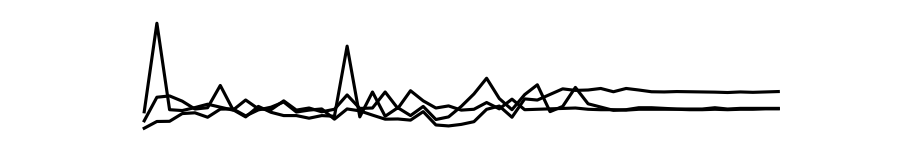

(-2.5, 52.5, -2.227983080495188, 6.991472286386167)

In [813]:
fig, ax = plt.subplots(1, figsize=(6,1))
ax.set_xticks([])
ax.set_yticks([])
ax.plot(Xr,c="black")
ax.axis("off")

In [703]:
X, Y = delayEmbed(Xr, 10, 1, 1)

x = X[-1]
weights = np.exp(-la.norm(X-x,axis=1)*0.5)

<IPython.core.display.Javascript object>


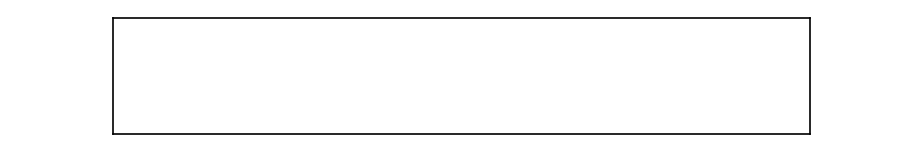

ValueError: 'c' argument has 254 elements, which is not acceptable for use with 'x' with size 40, 'y' with size 40.

In [814]:

fig, ax = plt.subplots(1, figsize=(6,1))
ax.set_xticks([])
ax.set_yticks([])
ax.scatter(np.arange(Y.shape[0]),X[:,0],c=weights,s=0.1,cmap="Reds")
ax.scatter(Y.shape[0], Y[-1], c="red", s=20, marker="o")
ax.plot(Y,c="black", alpha=0.1)
ax.axis('off')

In [803]:
Xr.shape

(51, 3)

<IPython.core.display.Javascript object>


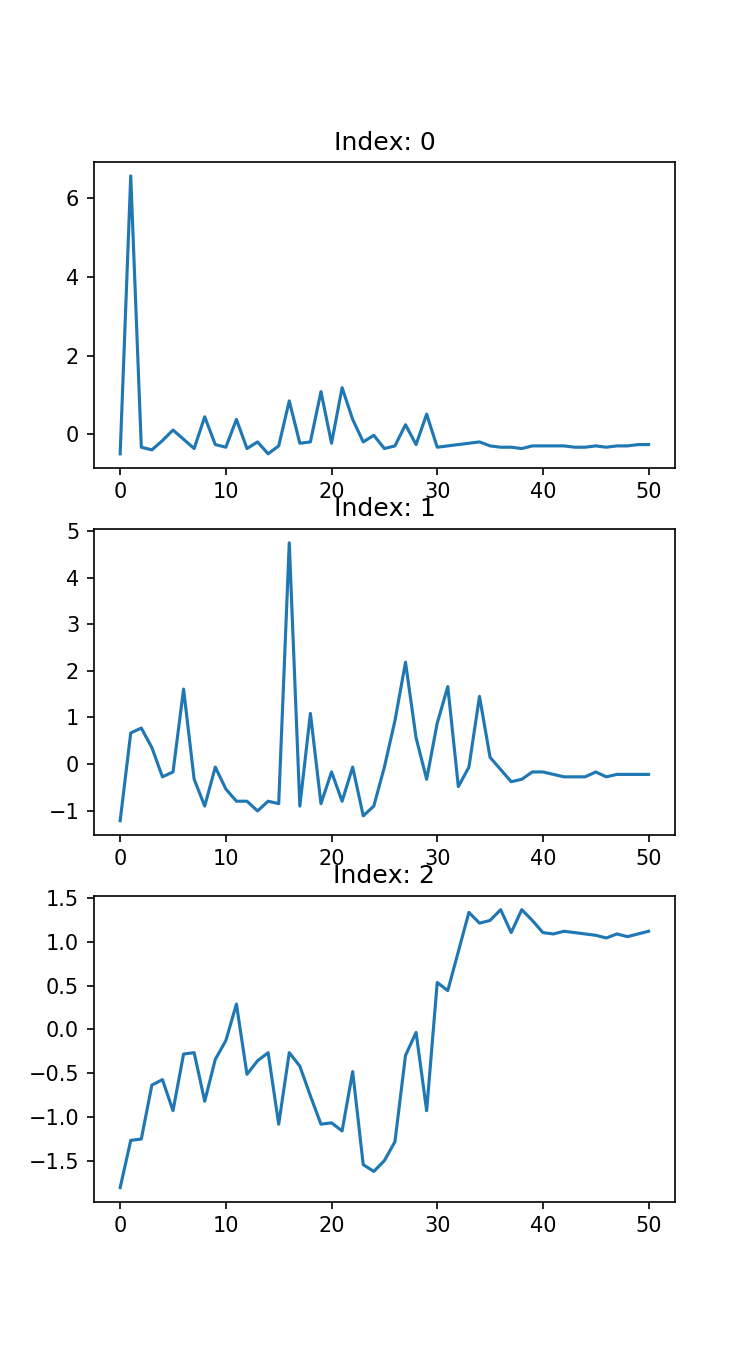

<IPython.core.display.Javascript object>


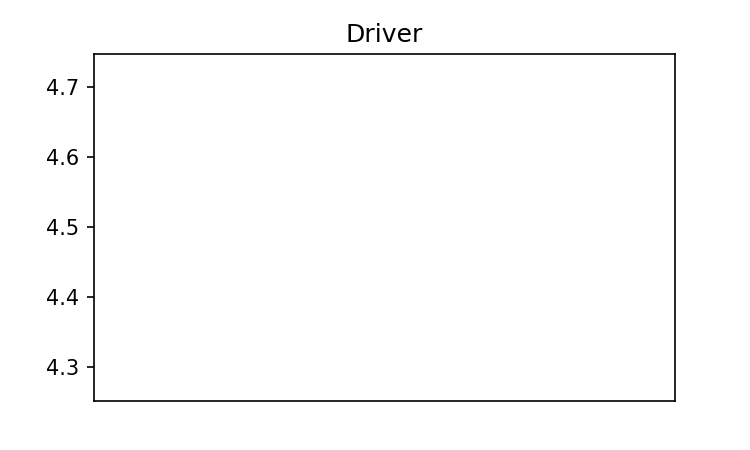

In [815]:
title = "Microcosm"

fig2 = plt.figure(2)

if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2], linewidth=1)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_xlabel("x(t)")
    ax2.set_ylabel("y(t)")
    ax2.set_zlabel("z(t)")
    
ax2.set_title(title)
    
""" 
ax2 = fig2.gca(projection="3d")
ax2.plot(t[settlingTime:],Xr[:,0],Xr[:,1])
ax2.set_xlabel("Time")
ax2.set_ylabel("Species 1 (standardized)")
ax2.set_zlabel("Species 2 (standardized)")
"""
# ax2.set_title("Rosenzweig MacArthur")
plt.savefig("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(5,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

plt.savefig("Individual Dimensions")
        
if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(5,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver")
        axD.plot(gtsr, c="tab:orange")
        axD.set_xticks([])
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
            
    plt.savefig("Drivers")
        
plt.show()

In [712]:
"""
n = 100
similarity_matrix = np.fromfunction(lambda i,j: np.exp(-((i-j)/n)**2), (n,n))
similarity_matrix = (similarity_matrix - np.mean(similarity_matrix) ) / np.var(similarity_matrix) * 8
"""

'\nn = 100\nsimilarity_matrix = np.fromfunction(lambda i,j: np.exp(-((i-j)/n)**2), (n,n))\nsimilarity_matrix = (similarity_matrix - np.mean(similarity_matrix) ) / np.var(similarity_matrix) * 8\n'

In [816]:
#embedding = MDS(dissimilarity="precomputed", n_components=10)
#X_transformed = embedding.fit_transform(similarity_matrix)

In [817]:
#fig, ax = plt.subplots(1)
#ax.plot(X_transformed[:,0])
#plt.show()

In [818]:
# transformed = MDStimescaleDecomp(Xr)

In [819]:
weights/np.ptp(weights)

array([1.53531195e-02, 2.84272300e-01, 3.02124064e-02, 4.75138078e-04,
       5.41615512e-05, 7.98453777e-05, 2.10952237e-04, 1.28908268e-03,
       2.54541253e-02, 6.62752568e-01, 4.61905912e-02, 1.16935255e-03,
       1.96503983e-04, 1.57648441e-04, 1.42809347e-04, 1.20382334e-04,
       9.32272268e-05, 6.74428616e-05, 4.70889064e-05, 3.30074908e-05,
       2.40391727e-05, 1.85609415e-05, 1.52613984e-05, 1.32785939e-05,
       1.20981689e-05, 1.14292888e-05, 1.11183766e-05, 1.11017948e-05,
       1.13901500e-05, 1.20867468e-05, 1.34719411e-05, 1.62900600e-05,
       2.29106180e-05, 4.41750072e-05, 1.80274549e-04, 4.10891654e-03,
       8.73558560e-02, 1.86608224e-01, 1.30850404e-03, 4.86104581e-05,
       5.49027116e-05, 1.56917488e-04, 1.38231695e-03, 4.32229660e-02,
       1.00000780e+00, 8.75121745e-03, 2.40486123e-04, 8.15203485e-05,
       1.15891465e-04, 2.25076017e-04, 6.34444969e-04, 3.00586733e-03,
       2.13886062e-02, 7.98104569e-02, 2.28271112e-02, 2.35231577e-03,
      

In [820]:
M

array([[-1.54911754, -0.24936496,  1.        ],
       [-2.36511853, -1.54911754,  1.        ],
       [-0.59006014, -2.36511853,  1.        ],
       [ 0.51682127, -0.59006014,  1.        ],
       [ 0.49646844,  0.51682127,  1.        ],
       [ 0.35140958,  0.49646844,  1.        ],
       [ 0.08152215,  0.35140958,  1.        ],
       [-0.44326976,  0.08152215,  1.        ],
       [-1.35942581, -0.44326976,  1.        ],
       [-1.81322237, -1.35942581,  1.        ],
       [-0.56483603, -1.81322237,  1.        ],
       [ 0.19641575, -0.56483603,  1.        ],
       [ 0.27479553,  0.19641575,  1.        ],
       [ 0.28970993,  0.27479553,  1.        ],
       [ 0.31626403,  0.28970993,  1.        ],
       [ 0.36131692,  0.31626403,  1.        ],
       [ 0.42344075,  0.36131692,  1.        ],
       [ 0.49715465,  0.42344075,  1.        ],
       [ 0.57431207,  0.49715465,  1.        ],
       [ 0.64650636,  0.57431207,  1.        ],
       [ 0.70766242,  0.64650636,  1.   

In [821]:
H @ Yn

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 44 is different from 254)

In [822]:
H.shape

(1, 254)

In [720]:
pred_point = np.array([-1.75,-1.75])
pred_point_line = np.array([[-1.75,-1.75,-3],
                            [-1.75,-1.75, 1]])

norms = la.norm(Xn - pred_point,axis=1)
d = np.mean(norms)

weights = np.exp(-1*((thetaNS-3)*norms)/d)
W = np.diag(weights)

M = np.hstack([Xn, np.ones((Xn.shape[0],1))])
xaug = np.hstack([pred_point, 1])
xaug = np.reshape(xaug, (1,xaug.shape[0]))
C = la.pinv(W@M) @ W @ Yn

res = np.linspace(pred_point[0]-1,pred_point[0]+1,num=3)
Xm, Ym = np.meshgrid(res,res)
Zm = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        Zm[i,j] = np.dot(C.flatten(),np.array([Xm[i,j],Ym[i,j],1]))

<IPython.core.display.Javascript object>


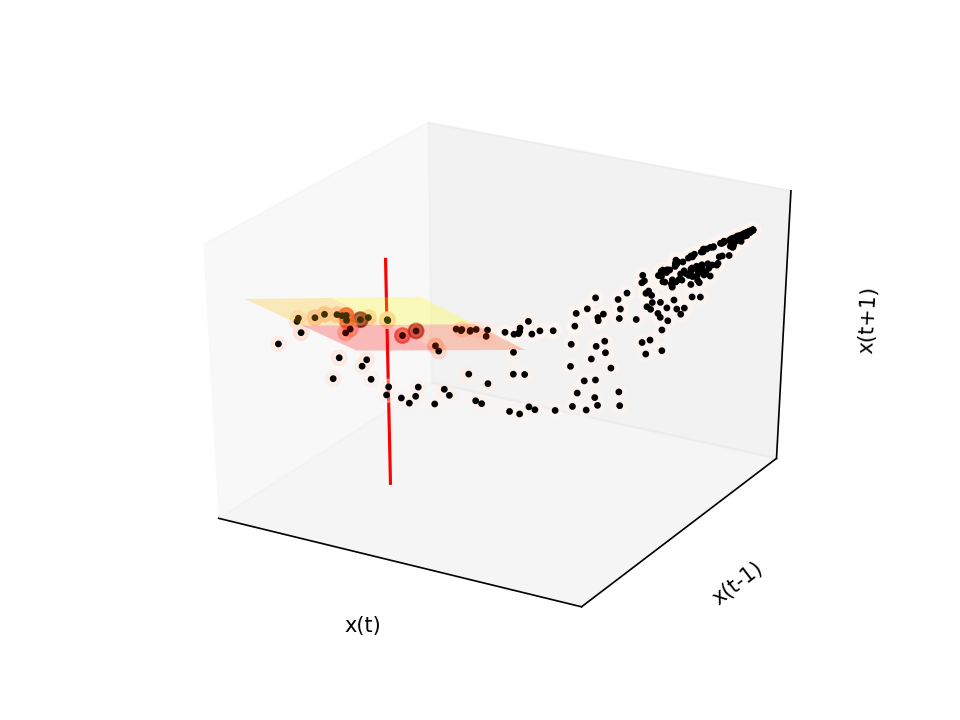

In [722]:


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(Xn[:,0],Xn[:,1],Yn,c=weights/np.ptp(weights),cmap="Reds",s=50)
ax.scatter(Xn[:,0],Xn[:,1],Yn,c='black',alpha=1,s=5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel("x(t)")
ax.set_ylabel("x(t-1)")
ax.set_zlabel("x(t+1)")
ax.plot(pred_point_line[:,0],pred_point_line[:,1],pred_point_line[:,2],c="red")
ax.plot_surface(Xm, Ym, Zm, alpha=0.25,cmap=cm.autumn)

<IPython.core.display.Javascript object>


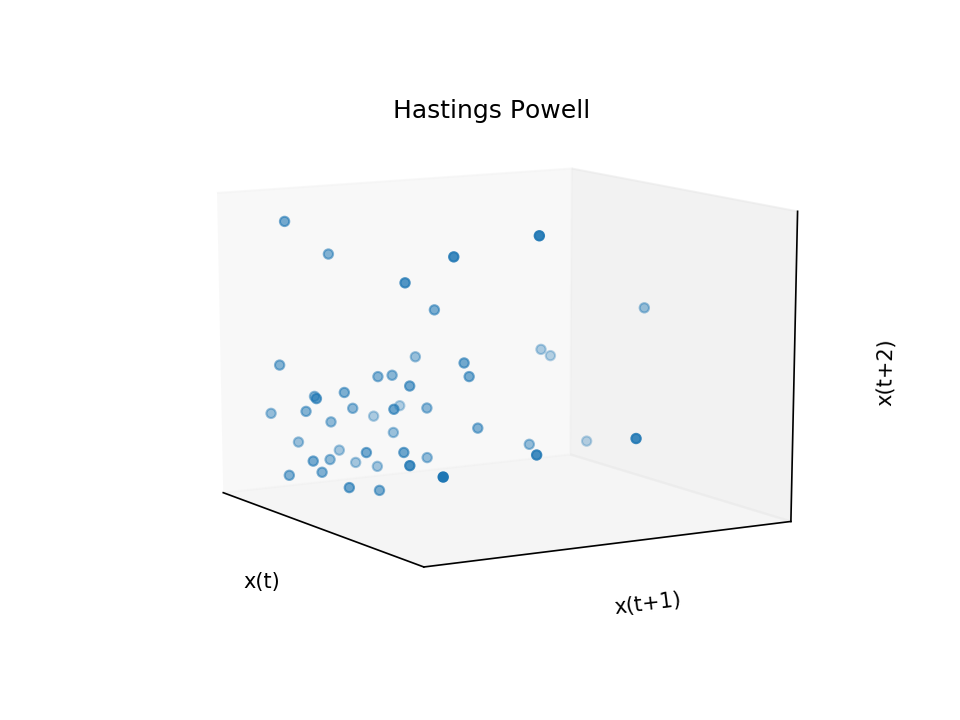

In [723]:
poincare3d(Xr[:,0], title=title, step=1)

<IPython.core.display.Javascript object>


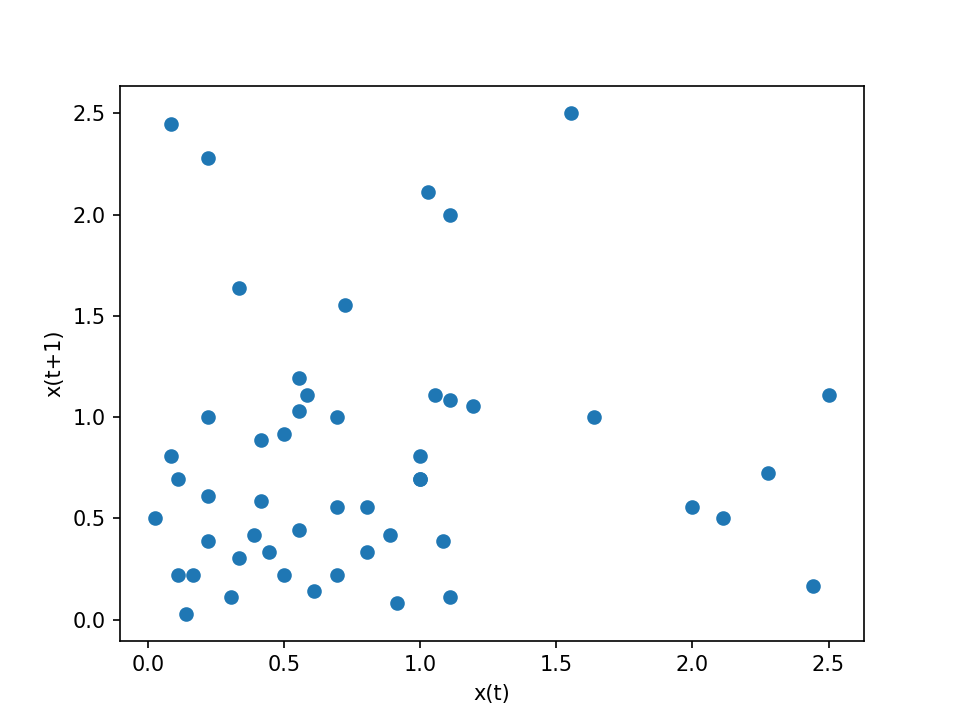

In [724]:
poincare2d(Xr, step = 1)

<IPython.core.display.Javascript object>


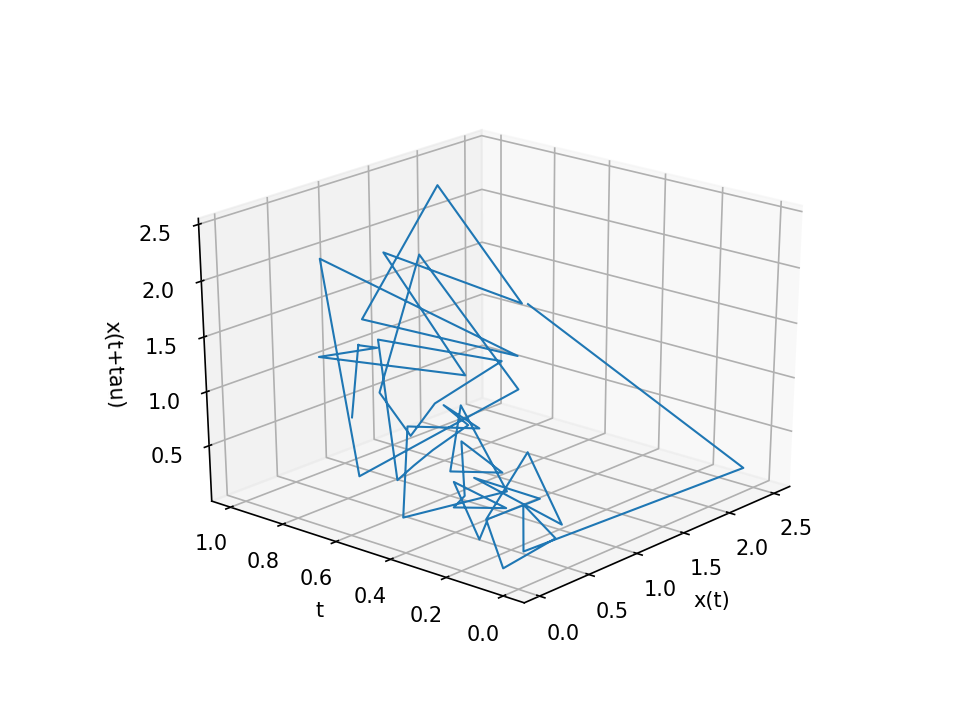

In [725]:
poincareT(Xr,step=1, scatter=False)

In [823]:
poincare3d(Xr, title=title,scatter=False)

ValueError: could not broadcast input array from shape (153,) into shape (51,)

<IPython.core.display.Javascript object>


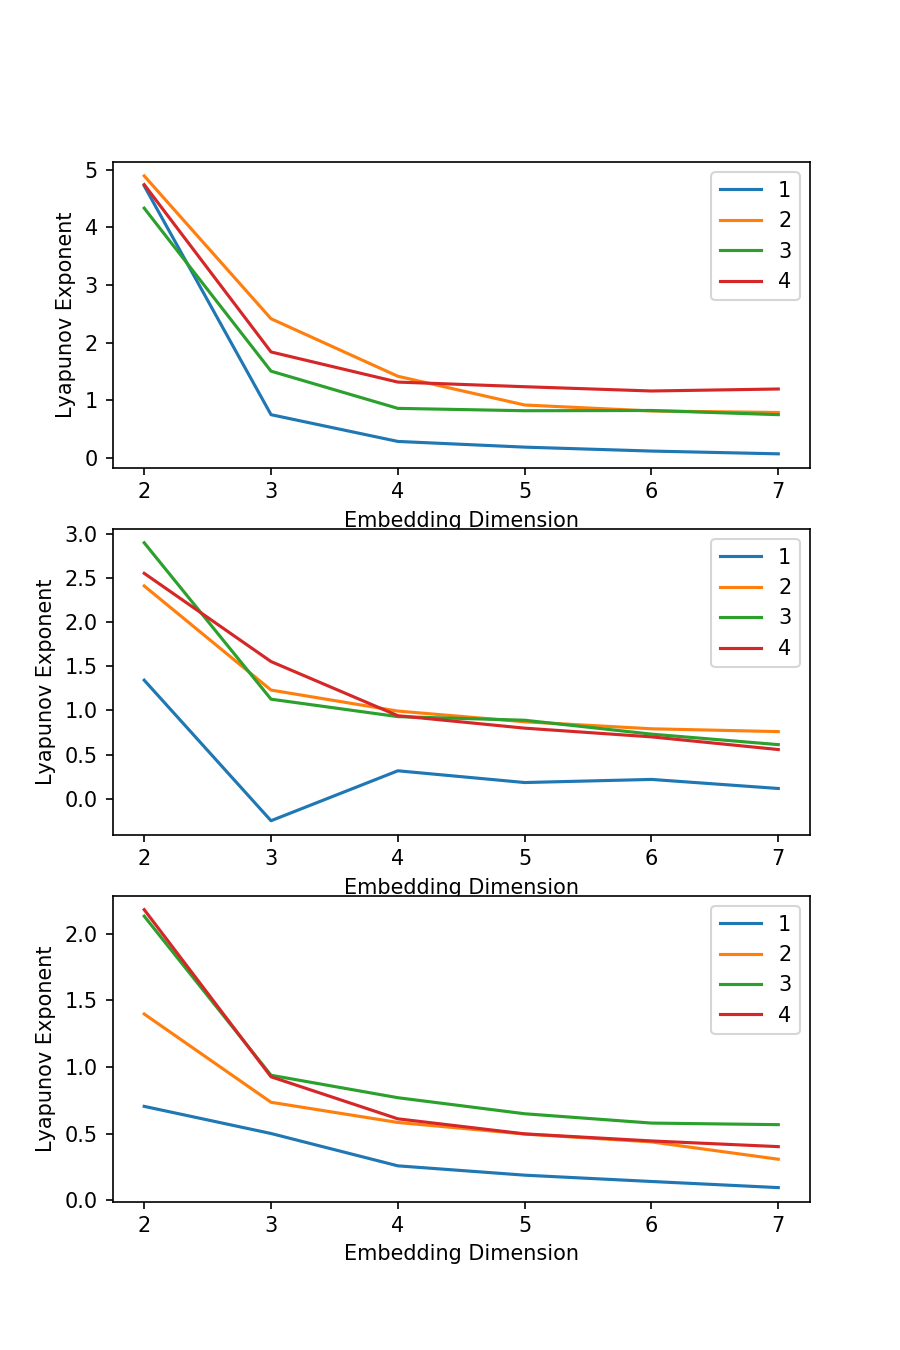

In [824]:
FNNplot(Xr, 5, 4)

In [825]:
predictionHorizon = 1
numLags = 1
lagStep = 1
maxLags = 5

In [826]:
tr.shape

(51,)

In [827]:
Xr.shape

(51, 3)

In [828]:
Xr[predictionHorizon:,0,None]

array([[ 6.57240613],
       [-0.3280263 ],
       [-0.39534759],
       [-0.15972306],
       [ 0.1095621 ],
       [-0.12606242],
       [-0.36168694],
       [ 0.44616856],
       [-0.260705  ],
       [-0.3280263 ],
       [ 0.37884727],
       [-0.36168694],
       [-0.19338371],
       [-0.49632952],
       [-0.29436565],
       [ 0.85009631],
       [-0.22704436],
       [-0.19338371],
       [ 1.08572084],
       [-0.22704436],
       [ 1.18670277],
       [ 0.37884727],
       [-0.19338371],
       [-0.02508048],
       [-0.36168694],
       [-0.29436565],
       [ 0.24420469],
       [-0.260705  ],
       [ 0.51348985],
       [-0.3280263 ],
       [-0.29436565],
       [-0.260705  ],
       [-0.22704436],
       [-0.19338371],
       [-0.29436565],
       [-0.3280263 ],
       [-0.3280263 ],
       [-0.36168694],
       [-0.29436565],
       [-0.29436565],
       [-0.29436565],
       [-0.29436565],
       [-0.3280263 ],
       [-0.3280263 ],
       [-0.29436565],
       [-0

In [829]:
Xr[:-predictionHorizon]

array([[-0.49632952, -1.2162804 , -1.80891693],
       [ 6.57240613,  0.6665955 , -1.26932523],
       [-0.3280263 ,  0.77119971, -1.25390832],
       [-0.39534759,  0.35278285, -0.6372321 ],
       [-0.15972306, -0.27484245, -0.57556448],
       [ 0.1095621 , -0.17023823, -0.93015331],
       [-0.12606242,  1.60803344, -0.28264327],
       [-0.36168694, -0.32714456, -0.26722636],
       [ 0.44616856, -0.90246775, -0.82223497],
       [-0.260705  , -0.06563402, -0.34431089],
       [-0.3280263 , -0.53635299, -0.12847421],
       [ 0.37884727, -0.79786353,  0.28778224],
       [-0.36168694, -0.79786353, -0.51389685],
       [-0.19338371, -1.00707197, -0.3597278 ],
       [-0.49632952, -0.79786353, -0.26722636],
       [-0.29436565, -0.85016564, -1.08432236],
       [ 0.85009631,  4.74615994, -0.26722636],
       [-0.22704436, -0.90246775, -0.42139542],
       [-0.19338371,  1.08501236, -0.76056734],
       [ 1.08572084, -0.85016564, -1.08432236],
       [-0.22704436, -0.17023823, -1.068

In [830]:
thetaNS, deltaNS, llikelihoodNS, lagsNS, thetaS, llikelihoodS, lagsS = optimizationSuite(Xr, tr, predictionHorizon, maxLags, lagStep, errFunc=logUnLikelihood, minLags=0)

Embedding Dimension = 2
NSMap
[01] theta: 0.000, delta: 0.000, log Likelihood: -80.353
[02] theta: 0.000, delta: 0.000, log Likelihood: -80.353
SMap
[01] theta: 0.000, delta: 0.000, log Likelihood: -80.353
[02] theta: 0.000, delta: 0.000, log Likelihood: -80.353
Embedding Dimension = 3
NSMap
[01] theta: 0.000, delta: 0.000, log Likelihood: -27.260
[02] theta: 0.000, delta: 0.000, log Likelihood: -27.260
SMap
[01] theta: 0.000, delta: 0.000, log Likelihood: -27.260
[02] theta: 0.000, delta: 0.000, log Likelihood: -27.260
Embedding Dimension = 4
NSMap
[01] theta: 0.000, delta: 0.000, log Likelihood: -36.820
[02] theta: 0.000, delta: 0.000, log Likelihood: -36.820
SMap
[01] theta: 0.000, delta: 0.000, log Likelihood: -36.820
[02] theta: 0.000, delta: 0.000, log Likelihood: -36.820
Embedding Dimension = 5
NSMap
[01] theta: 0.000, delta: 0.000, log Likelihood: -39.875
[02] theta: 0.000, delta: 0.000, log Likelihood: -39.875
SMap
[01] theta: 0.000, delta: 0.000, log Likelihood: -39.875
[02] 

In [831]:
""" COMPUTE DOFS """
"""
Xn, Yn, txn = delayEmbed(Xr, predictionHorizon, lagsNS, lagStep, t=t)
dofNS = dofestimation(Xn, Yn, txn, thetaNS, deltaNS)

Xs, Ys, txs = delayEmbed(Xr, predictionHorizon, lagsS, lagStep, t=t)
dofS = dofestimation(Xs, Ys, txs, thetaS, 0)
"""

emb_array = (np.ones(Xr.shape[1])*lagsNS).astype(int)
Xn, Yn = delayEmbedM(Xr[:-predictionHorizon], Xr[predictionHorizon:,0,None], emb_array, lagStep)
txn = np.linspace(0,1,num=Xn.shape[0])

emb_array = (np.ones(Xr.shape[1])*lagsS).astype(int)
Xs, Ys = delayEmbedM(Xr[:-predictionHorizon], Xr[predictionHorizon:,0,None], emb_array, lagStep)
txs = np.linspace(0,1,num=Xs.shape[0])

dofNS = dofestimation(Xn, Yn, txn, thetaNS, deltaNS)
dofS = dofestimation(Xs, Ys, txs, thetaS, 0)

In [832]:
predictedTSNS = leaveOneOut(Xn, Yn, txn, thetaNS, deltaNS)
predictedTSS = leaveOneOut(Xs, Ys, txs, thetaS, 0)

In [833]:
MSElooNS = np.sum((predictedTSNS - Yn) ** 2 )
MSElooS = np.sum((predictedTSS - Ys) ** 2 )

<IPython.core.display.Javascript object>


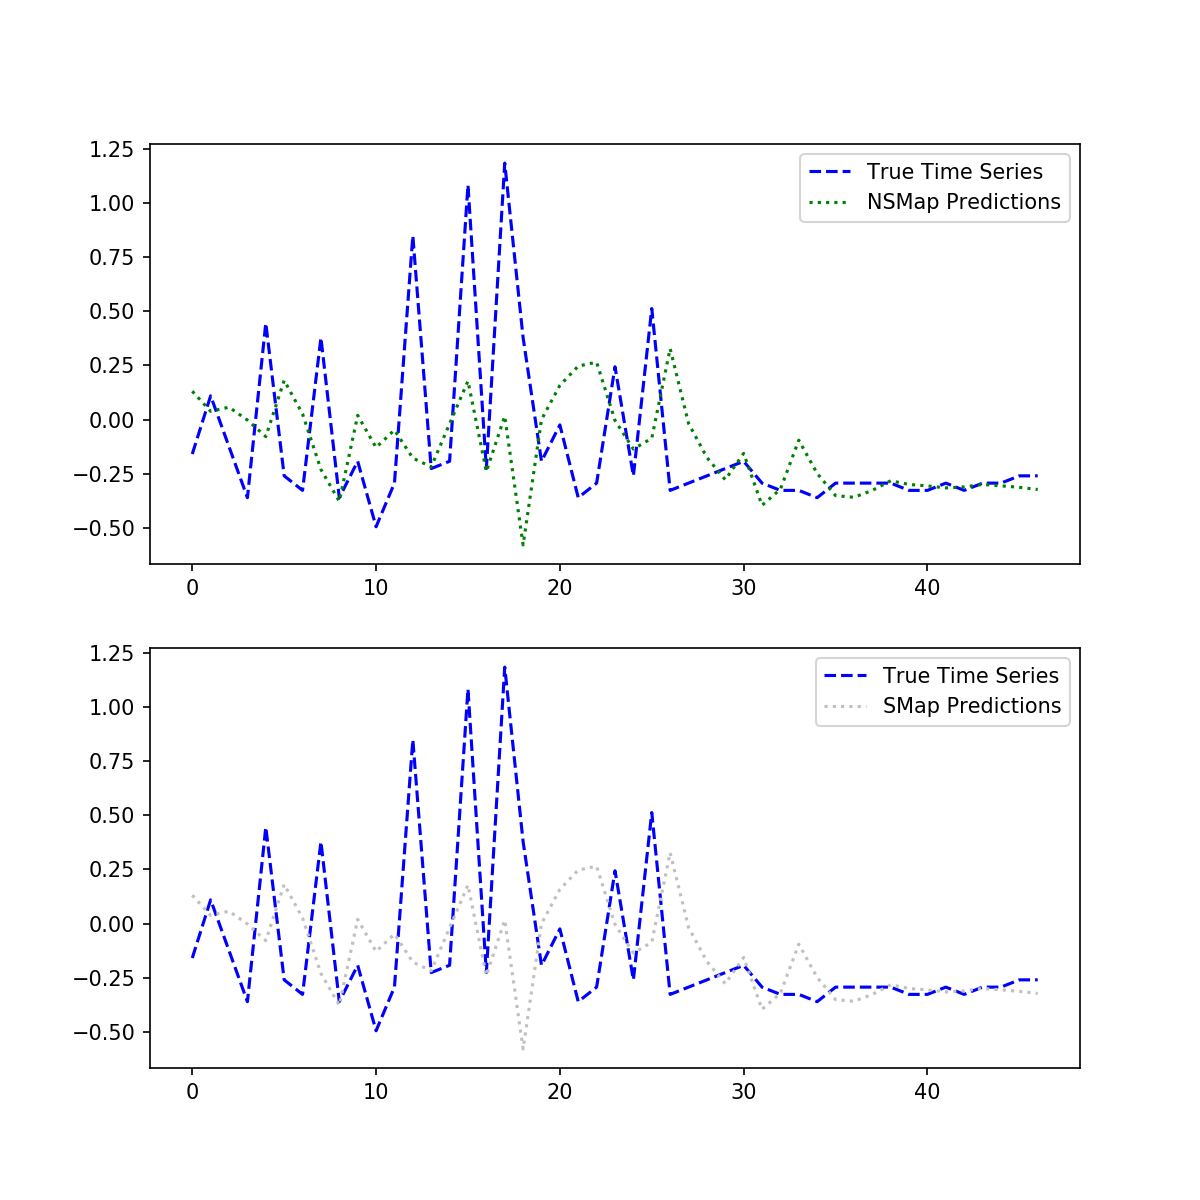

In [834]:
figLOU, axLOU = plt.subplots(2, figsize=(8,8))
axLOU[0].plot(Yn, c="blue", linestyle="dashed", label="True Time Series")
axLOU[0].plot(predictedTSNS, c="green", linestyle="dotted", label="NSMap Predictions")
axLOU[0].legend()

axLOU[1].plot(Ys, c="blue", linestyle="dashed", label="True Time Series")
axLOU[1].plot(predictedTSS, c="silver", linestyle="dotted", label="SMap Predictions")
axLOU[1].legend()
plt.show()

In [835]:
AICNS = AIC(Xn, Yn, txn, thetaNS, deltaNS)
AICS = AIC(Xs, Ys, txs, thetaS, 0)

In [836]:
sequentialNS = sequential(Xn, Yn, txn, thetaNS, deltaNS,return_error=False)
sequentialS = sequential(Xs, Ys, txs, thetaS, 0,return_error=False)

YseqNS = Yn[int(Yn.shape[0]/2):]
YseqS = Ys[int(Ys.shape[0]/2):]

In [837]:
MSEseqNS = np.mean((sequentialNS-YseqNS)**2)
MSEseqS = np.mean((sequentialS-YseqS)**2)

<IPython.core.display.Javascript object>


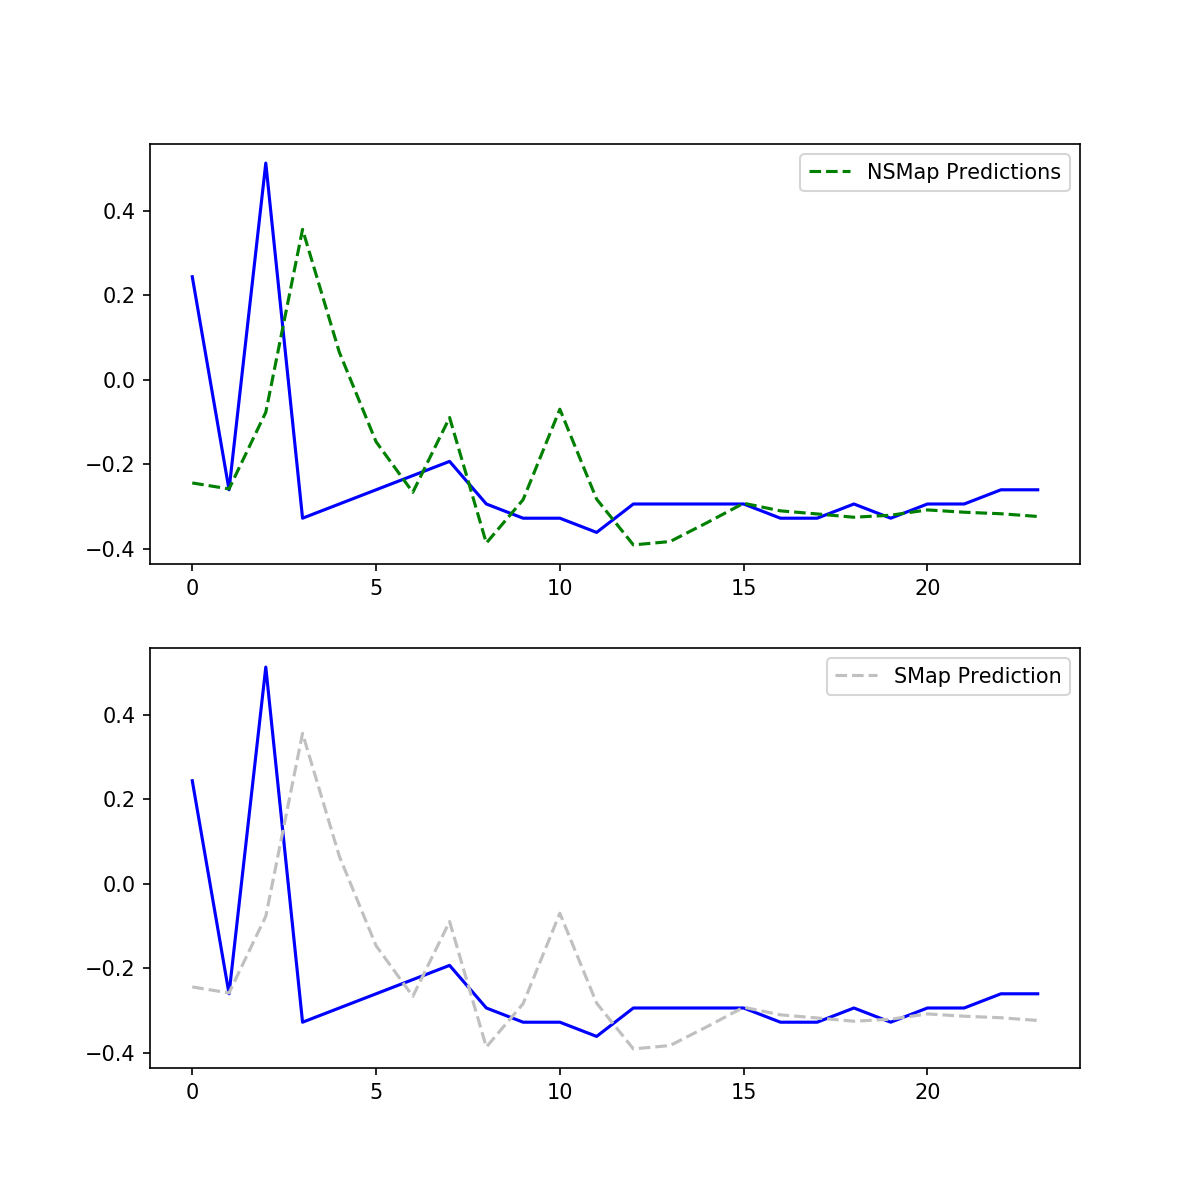

In [838]:
fig, ax = plt.subplots(2, figsize=(8,8))
ax[0].plot(Yn[int(Yn.shape[0]/2):], color="blue")
ax[0].plot(sequentialNS, color="green", linestyle="dashed", label="NSMap Predictions")
ax[0].text(38,0.65,f"Improvement of NSMap = {MSEseqS/MSEseqNS:.4f}")
ax[0].legend()

ax[1].plot(Ys[int(Ys.shape[0]/2):], color="blue")
ax[1].plot(sequentialS, color="silver", linestyle="dashed", label="SMap Prediction")
ax[1].legend()

plt.show()

In [799]:
# functionSurfaceNSMap(Xr, predictionHorizon, thetaBestNS, deltaBestNS, 15)

In [839]:
### SUMMARY ###

print(f"NSMap -- theta: {thetaNS:.3f}, delta: {deltaNS:.7f}, AIC: {AICNS:.3f}, log Likelihood: {llikelihoodNS:.3f}, Optimal Embedding Dimension: {lagsNS+2}, 10% Weight Dropoff: {np.exp(-deltaNS*0.1**2)}")
print(f"SMap -- theta: {thetaS:.3f}, AIC: {AICS:.3f}, log Likelihood: {llikelihoodS:.3f}, Optimal Embedding Dimension: {lagsS+2}")

print(f"Improvement of NSMap(leave one out): {MSElooS/MSElooNS:.3f}")
print(f"Improvement of NSMap(sequentially calculated): {MSEseqS/MSEseqNS:.3f}")

print(f"NSMap dof: {dofNS:.3f}")
print(f"SMap dof: {dofS:.3f}")

AkaikeTest(AICS, AICNS)

NSMap -- theta: 0.000, delta: 0.0000000, AIC: 68.520, log Likelihood: -27.260, Optimal Embedding Dimension: 3, 10% Weight Dropoff: 1.0
SMap -- theta: 0.000, AIC: 68.520, log Likelihood: -27.260, Optimal Embedding Dimension: 3
Improvement of NSMap(leave one out): 1.000
Improvement of NSMap(sequentially calculated): 1.000
NSMap dof: 7.000
SMap dof: 7.000
Probability NSMap beats SMap:  1.0


In [6]:
np.exp(-1.1625869)

0.3126762715102207

In [36]:
def driverVdelta(resolution, theta, lags, lagStep):
    # Final data will be
    # Nonstat Rate(0,1)|theta|delta|err(l1o)|err(seq)|dof
    
    table = np.zeros((resolution, 7))
    
    x0 = np.array([0.1,0.4,9])
    for r in range(resolution):
        rate = float(r)/resolution
        b1 = lambda t: 2.5 + rate * 4 * t / end
        
        Xr = standardize(generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime))[:,0,None]
        predictionHorizon = 1
        
        plotTS(Xr)
        
        X, Y, tx = delayEmbed(Xr, predictionHorizon, lags, lagStep, t=t)

        print(theta)
        
        theta, delta, err = optimizeG(X, Y, tx, hp=np.array([theta,0.0]), fixed=np.array([True, False]))
        
        dof = dofestimation(X, Y, tx, theta, delta)
        
        MSE = sequential(X, Y, tx, theta, delta, return_error=True)
        print(rate, theta, delta, err, MSE, lags, dof)
        stinky = np.array([rate, theta, delta, err, MSE, lags, dof])
        for pp in range(7):
            table[r,pp] = stinky[pp]
        
    return table

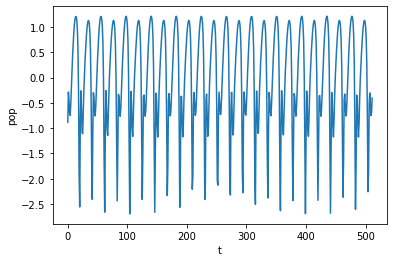

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 2900.803
[02] theta: 7.817, delta: 0.000, log Likelihood: 2900.803
0.0 7.817299496875003 0.0 -2900.8026699650495 9.835623377872334e-05 2 103.84771399383631


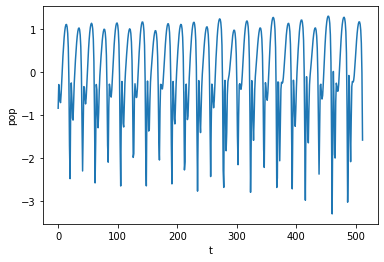

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 1972.846
[02] theta: 7.817, delta: 1.100, log Likelihood: 1993.548
[03] theta: 7.817, delta: 0.550, log Likelihood: 1988.970
[04] theta: 7.817, delta: 0.825, log Likelihood: 1992.578
[05] theta: 7.817, delta: 1.128, log Likelihood: 1993.510
[06] theta: 7.817, delta: 0.976, log Likelihood: 1993.421
[07] theta: 7.817, delta: 1.052, log Likelihood: 1993.556
[08] theta: 7.817, delta: 1.135, log Likelihood: 1993.495
[09] theta: 7.817, delta: 1.093, log Likelihood: 1993.553
[10] theta: 7.817, delta: 1.048, log Likelihood: 1993.554
0.04 7.817299496875003 1.047715625 -1993.5538030980065 0.0009560066920683453 2 163.1382476187612


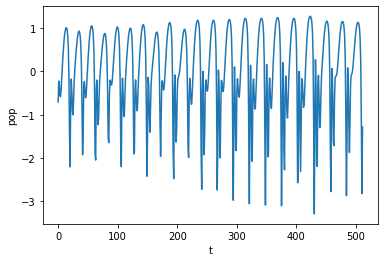

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 1520.950
[02] theta: 7.817, delta: 1.100, log Likelihood: 1512.111
[03] theta: 7.817, delta: 0.550, log Likelihood: 1519.866
[04] theta: 7.817, delta: 0.000, log Likelihood: 1520.950
[05] theta: 7.817, delta: 0.303, log Likelihood: 1521.303
[06] theta: 7.817, delta: 0.151, log Likelihood: 1521.436
[07] theta: 7.817, delta: 0.227, log Likelihood: 1521.444
0.08 7.817299496875003 0.22687500000000005 -1521.444418433879 0.0027497160414356246 2 157.64094992048672


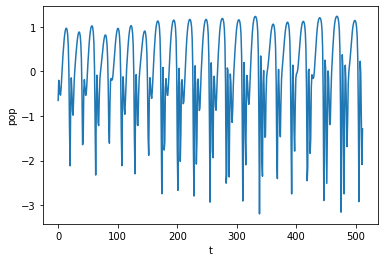

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 1288.278
[02] theta: 7.817, delta: 1.100, log Likelihood: 1317.715
[03] theta: 7.817, delta: 2.310, log Likelihood: 1327.454
[04] theta: 7.817, delta: 3.641, log Likelihood: 1324.971
[05] theta: 7.817, delta: 2.976, log Likelihood: 1327.302
[06] theta: 7.817, delta: 2.243, log Likelihood: 1327.310
0.12 7.817299496875003 2.24345 -1327.3096250324334 0.0030694593957320895 2 192.44455306097618


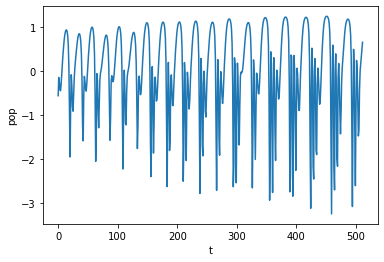

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 1030.100
[02] theta: 7.817, delta: 1.100, log Likelihood: 1076.730
[03] theta: 7.817, delta: 2.310, log Likelihood: 1102.799
[04] theta: 7.817, delta: 3.641, log Likelihood: 1105.418
[05] theta: 7.817, delta: 2.976, log Likelihood: 1106.783
[06] theta: 7.817, delta: 3.308, log Likelihood: 1106.643
[07] theta: 7.817, delta: 3.142, log Likelihood: 1106.864
[08] theta: 7.817, delta: 2.959, log Likelihood: 1106.757
[09] theta: 7.817, delta: 3.050, log Likelihood: 1106.859
[10] theta: 7.817, delta: 3.151, log Likelihood: 1106.860
0.16 7.817299496875003 3.151025625000001 -1106.8596430184346 0.005633761112830033 2 212.57761330469646


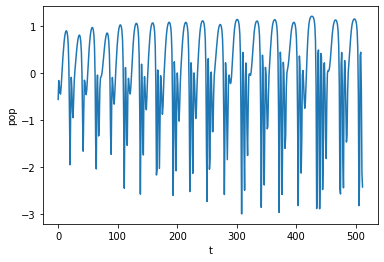

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 835.727
[02] theta: 7.817, delta: 1.100, log Likelihood: 903.654
[03] theta: 7.817, delta: 2.310, log Likelihood: 956.352
[04] theta: 7.817, delta: 3.641, log Likelihood: 980.754
[05] theta: 7.817, delta: 5.105, log Likelihood: 977.889
[06] theta: 7.817, delta: 4.373, log Likelihood: 982.122
[07] theta: 7.817, delta: 3.568, log Likelihood: 980.220
[08] theta: 7.817, delta: 3.970, log Likelihood: 982.208
[09] theta: 7.817, delta: 4.413, log Likelihood: 982.014
[10] theta: 7.817, delta: 4.192, log Likelihood: 982.392
[11] theta: 7.817, delta: 3.948, log Likelihood: 982.156
[12] theta: 7.817, delta: 4.070, log Likelihood: 982.364
[13] theta: 7.817, delta: 4.204, log Likelihood: 982.385
[14] theta: 7.817, delta: 4.137, log Likelihood: 982.401
[15] theta: 7.817, delta: 4.171, log Likelihood: 982.399
0.2 7.817299496875003 4.170553531718751 -982.399226398885 0.007420278783853597 2 218.07144728881113


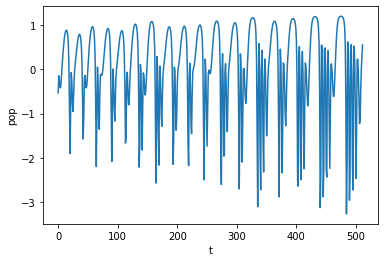

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 801.646
[02] theta: 7.817, delta: 1.100, log Likelihood: 824.234
[03] theta: 7.817, delta: 2.310, log Likelihood: 831.622
[04] theta: 7.817, delta: 3.641, log Likelihood: 829.749
[05] theta: 7.817, delta: 2.976, log Likelihood: 831.589
[06] theta: 7.817, delta: 2.243, log Likelihood: 831.500
[07] theta: 7.817, delta: 2.609, log Likelihood: 831.870
[08] theta: 7.817, delta: 3.012, log Likelihood: 831.529
[09] theta: 7.817, delta: 2.811, log Likelihood: 831.788
[10] theta: 7.817, delta: 2.589, log Likelihood: 831.867
[11] theta: 7.817, delta: 2.700, log Likelihood: 831.856
[12] theta: 7.817, delta: 2.645, log Likelihood: 831.869
[13] theta: 7.817, delta: 2.584, log Likelihood: 831.866
0.24 7.817299496875003 2.583807496875 -831.866333240742 0.0066009119856508145 2 207.83725156545435


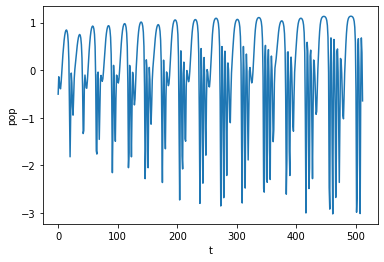

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 597.239
[02] theta: 7.817, delta: 1.100, log Likelihood: 661.842
[03] theta: 7.817, delta: 2.310, log Likelihood: 711.684
[04] theta: 7.817, delta: 3.641, log Likelihood: 744.759
[05] theta: 7.817, delta: 5.105, log Likelihood: 763.093
[06] theta: 7.817, delta: 6.716, log Likelihood: 770.463
[07] theta: 7.817, delta: 8.487, log Likelihood: 769.552
[08] theta: 7.817, delta: 7.601, log Likelihood: 770.932
[09] theta: 7.817, delta: 6.627, log Likelihood: 770.297
[10] theta: 7.817, delta: 7.114, log Likelihood: 770.929
[11] theta: 7.817, delta: 7.650, log Likelihood: 770.900
[12] theta: 7.817, delta: 7.382, log Likelihood: 771.003
[13] theta: 7.817, delta: 7.087, log Likelihood: 770.912
[14] theta: 7.817, delta: 7.235, log Likelihood: 770.985
[15] theta: 7.817, delta: 7.397, log Likelihood: 771.002
[16] theta: 7.817, delta: 7.316, log Likelihood: 771.002
0.28 7.817299496875003 7.315842547440627 -771.0020452881

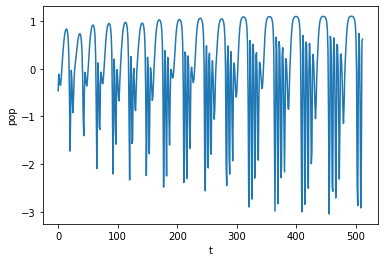

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 593.387
[02] theta: 7.817, delta: 1.100, log Likelihood: 665.363
[03] theta: 7.817, delta: 2.310, log Likelihood: 713.490
[04] theta: 7.817, delta: 3.641, log Likelihood: 736.153
[05] theta: 7.817, delta: 5.105, log Likelihood: 742.715
[06] theta: 7.817, delta: 6.716, log Likelihood: 739.634
[07] theta: 7.817, delta: 5.910, log Likelihood: 742.069
[08] theta: 7.817, delta: 5.025, log Likelihood: 742.652
[09] theta: 7.817, delta: 5.467, log Likelihood: 742.693
[10] theta: 7.817, delta: 5.246, log Likelihood: 742.765
[11] theta: 7.817, delta: 5.357, log Likelihood: 742.751
[12] theta: 7.817, delta: 5.301, log Likelihood: 742.763
[13] theta: 7.817, delta: 5.240, log Likelihood: 742.764
0.32 7.817299496875003 5.240483496875003 -742.7640861206233 0.008031764253578374 2 224.87853893317816


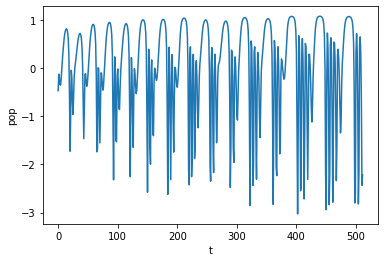

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 507.444
[02] theta: 7.817, delta: 1.100, log Likelihood: 567.360
[03] theta: 7.817, delta: 2.310, log Likelihood: 605.208
[04] theta: 7.817, delta: 3.641, log Likelihood: 625.265
[05] theta: 7.817, delta: 5.105, log Likelihood: 635.040
[06] theta: 7.817, delta: 6.716, log Likelihood: 637.341
[07] theta: 7.817, delta: 5.910, log Likelihood: 637.100
[08] theta: 7.817, delta: 6.313, log Likelihood: 637.430
[09] theta: 7.817, delta: 6.756, log Likelihood: 637.310
[10] theta: 7.817, delta: 6.534, log Likelihood: 637.431
[11] theta: 7.817, delta: 6.291, log Likelihood: 637.423
0.36 7.817299496875003 6.2908379875000024 -637.4230161618678 0.007363379983504659 2 239.22716393249237


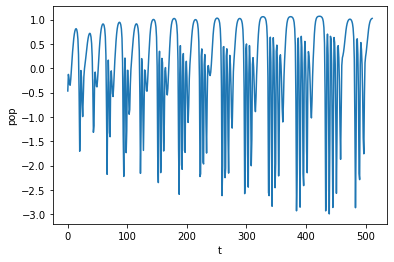

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 322.196
[02] theta: 7.817, delta: 1.100, log Likelihood: 422.694
[03] theta: 7.817, delta: 2.310, log Likelihood: 507.053
[04] theta: 7.817, delta: 3.641, log Likelihood: 562.978
[05] theta: 7.817, delta: 5.105, log Likelihood: 593.064
[06] theta: 7.817, delta: 6.716, log Likelihood: 605.157
[07] theta: 7.817, delta: 8.487, log Likelihood: 604.207
[08] theta: 7.817, delta: 7.601, log Likelihood: 606.078
[09] theta: 7.817, delta: 6.627, log Likelihood: 604.878
[10] theta: 7.817, delta: 7.114, log Likelihood: 605.970
[11] theta: 7.817, delta: 7.650, log Likelihood: 606.041
[12] theta: 7.817, delta: 7.382, log Likelihood: 606.142
[13] theta: 7.817, delta: 7.516, log Likelihood: 606.124
[14] theta: 7.817, delta: 7.449, log Likelihood: 606.141
[15] theta: 7.817, delta: 7.375, log Likelihood: 606.141
0.4 7.817299496875003 7.375461111218751 -606.1406661180649 0.0075299276955474335 2 241.61416091336298


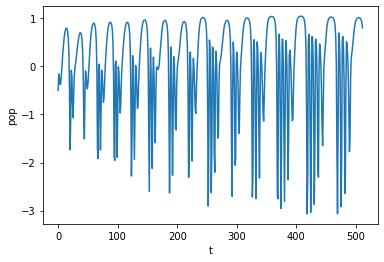

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 316.672
[02] theta: 7.817, delta: 1.100, log Likelihood: 395.611
[03] theta: 7.817, delta: 2.310, log Likelihood: 451.285
[04] theta: 7.817, delta: 3.641, log Likelihood: 481.011
[05] theta: 7.817, delta: 5.105, log Likelihood: 495.354
[06] theta: 7.817, delta: 6.716, log Likelihood: 501.531
[07] theta: 7.817, delta: 8.487, log Likelihood: 502.398
[08] theta: 7.817, delta: 7.601, log Likelihood: 502.560
[09] theta: 7.817, delta: 8.044, log Likelihood: 502.613
[10] theta: 7.817, delta: 7.823, log Likelihood: 502.622
0.44 7.817299496875003 7.822835625000002 -502.62156486295055 0.008422895080884406 2 242.61293292158018


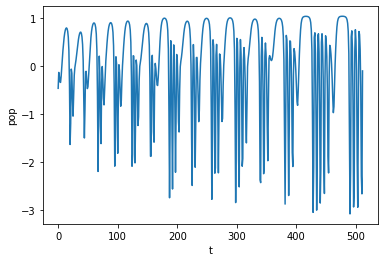

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 372.410
[02] theta: 7.817, delta: 1.100, log Likelihood: 439.538
[03] theta: 7.817, delta: 2.310, log Likelihood: 479.559
[04] theta: 7.817, delta: 3.641, log Likelihood: 502.072
[05] theta: 7.817, delta: 5.105, log Likelihood: 517.051
[06] theta: 7.817, delta: 6.716, log Likelihood: 527.561
[07] theta: 7.817, delta: 8.487, log Likelihood: 533.481
[08] theta: 7.817, delta: 10.436, log Likelihood: 533.798
[09] theta: 7.817, delta: 9.462, log Likelihood: 534.412
[10] theta: 7.817, delta: 9.949, log Likelihood: 534.292
[11] theta: 7.817, delta: 9.705, log Likelihood: 534.400
[12] theta: 7.817, delta: 9.437, log Likelihood: 534.408
0.48 7.817299496875003 9.437170586250007 -534.4082074019649 0.011352733252217605 2 250.59970401497486


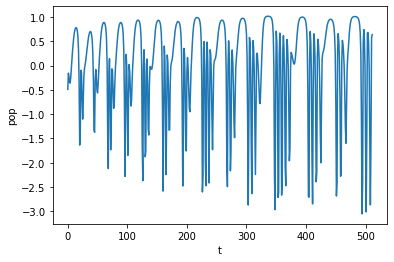

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 237.295
[02] theta: 7.817, delta: 1.100, log Likelihood: 326.896
[03] theta: 7.817, delta: 2.310, log Likelihood: 382.854
[04] theta: 7.817, delta: 3.641, log Likelihood: 406.328
[05] theta: 7.817, delta: 5.105, log Likelihood: 412.288
[06] theta: 7.817, delta: 6.716, log Likelihood: 410.226
[07] theta: 7.817, delta: 5.910, log Likelihood: 411.878
[08] theta: 7.817, delta: 5.025, log Likelihood: 412.230
[09] theta: 7.817, delta: 5.467, log Likelihood: 412.304
[10] theta: 7.817, delta: 5.246, log Likelihood: 412.340
[11] theta: 7.817, delta: 5.357, log Likelihood: 412.339
0.52 7.817299496875003 5.356742187500003 -412.33860531970925 0.0128197290900374 2 227.5971987518693


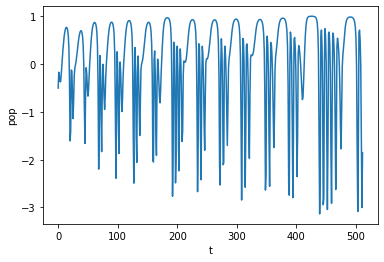

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 174.950
[02] theta: 7.817, delta: 1.100, log Likelihood: 235.865
[03] theta: 7.817, delta: 2.310, log Likelihood: 286.200
[04] theta: 7.817, delta: 3.641, log Likelihood: 325.172
[05] theta: 7.817, delta: 5.105, log Likelihood: 354.462
[06] theta: 7.817, delta: 6.716, log Likelihood: 374.342
[07] theta: 7.817, delta: 8.487, log Likelihood: 385.115
[08] theta: 7.817, delta: 10.436, log Likelihood: 388.375
[09] theta: 7.817, delta: 12.579, log Likelihood: 386.161
[10] theta: 7.817, delta: 11.508, log Likelihood: 387.806
[11] theta: 7.817, delta: 10.329, log Likelihood: 388.357
[12] theta: 7.817, delta: 10.918, log Likelihood: 388.277
[13] theta: 7.817, delta: 10.623, log Likelihood: 388.371
[14] theta: 7.817, delta: 10.299, log Likelihood: 388.350
[15] theta: 7.817, delta: 10.461, log Likelihood: 388.377
[16] theta: 7.817, delta: 10.640, log Likelihood: 388.368
0.56 7.817299496875003 10.63966301125063 -388.3

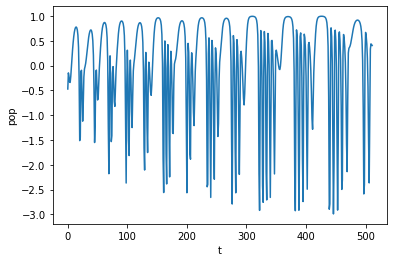

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 215.050
[02] theta: 7.817, delta: 1.100, log Likelihood: 352.139
[03] theta: 7.817, delta: 2.310, log Likelihood: 460.919
[04] theta: 7.817, delta: 3.641, log Likelihood: 526.020
[05] theta: 7.817, delta: 5.105, log Likelihood: 560.435
[06] theta: 7.817, delta: 6.716, log Likelihood: 577.127
[07] theta: 7.817, delta: 8.487, log Likelihood: 583.113
[08] theta: 7.817, delta: 10.436, log Likelihood: 581.455
[09] theta: 7.817, delta: 9.462, log Likelihood: 583.111
[10] theta: 7.817, delta: 8.390, log Likelihood: 583.006
[11] theta: 7.817, delta: 8.926, log Likelihood: 583.344
[12] theta: 7.817, delta: 9.515, log Likelihood: 583.059
[13] theta: 7.817, delta: 9.220, log Likelihood: 583.281
[14] theta: 7.817, delta: 8.896, log Likelihood: 583.341
[15] theta: 7.817, delta: 9.058, log Likelihood: 583.336
0.6 7.817299496875003 9.058266905118755 -583.336302456171 0.010426429104263326 2 245.05871367242418


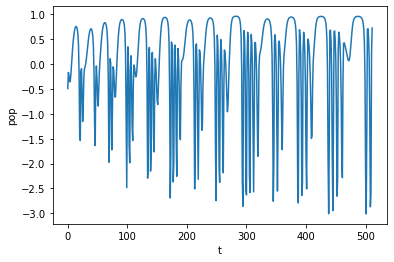

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 137.743
[02] theta: 7.817, delta: 1.100, log Likelihood: 205.430
[03] theta: 7.817, delta: 2.310, log Likelihood: 258.154
[04] theta: 7.817, delta: 3.641, log Likelihood: 295.790
[05] theta: 7.817, delta: 5.105, log Likelihood: 321.691
[06] theta: 7.817, delta: 6.716, log Likelihood: 338.695
[07] theta: 7.817, delta: 8.487, log Likelihood: 348.371
[08] theta: 7.817, delta: 10.436, log Likelihood: 351.419
[09] theta: 7.817, delta: 9.462, log Likelihood: 350.740
[10] theta: 7.817, delta: 9.949, log Likelihood: 351.276
[11] theta: 7.817, delta: 10.485, log Likelihood: 351.412
[12] theta: 7.817, delta: 10.217, log Likelihood: 351.401
[13] theta: 7.817, delta: 10.351, log Likelihood: 351.421
[14] theta: 7.817, delta: 10.498, log Likelihood: 351.410
[15] theta: 7.817, delta: 10.424, log Likelihood: 351.420
0.64 7.817299496875003 10.424317592218758 -351.41951089999526 0.010578877755963488 2 248.59842004078607


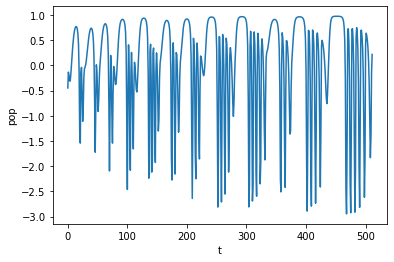

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 45.695
[02] theta: 7.817, delta: 1.100, log Likelihood: 152.204
[03] theta: 7.817, delta: 2.310, log Likelihood: 232.232
[04] theta: 7.817, delta: 3.641, log Likelihood: 280.904
[05] theta: 7.817, delta: 5.105, log Likelihood: 308.678
[06] theta: 7.817, delta: 6.716, log Likelihood: 322.096
[07] theta: 7.817, delta: 8.487, log Likelihood: 325.879
[08] theta: 7.817, delta: 10.436, log Likelihood: 323.568
[09] theta: 7.817, delta: 9.462, log Likelihood: 325.290
[10] theta: 7.817, delta: 8.390, log Likelihood: 325.857
[11] theta: 7.817, delta: 8.926, log Likelihood: 325.783
[12] theta: 7.817, delta: 8.658, log Likelihood: 325.878
[13] theta: 7.817, delta: 8.363, log Likelihood: 325.848
[14] theta: 7.817, delta: 8.510, log Likelihood: 325.882
[15] theta: 7.817, delta: 8.672, log Likelihood: 325.876
0.68 7.817299496875003 8.672420919318755 -325.876081229311 0.015400571842642957 2 246.51126601529785


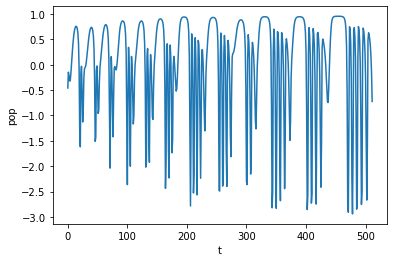

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 159.837
[02] theta: 7.817, delta: 1.100, log Likelihood: 268.273
[03] theta: 7.817, delta: 2.310, log Likelihood: 339.733
[04] theta: 7.817, delta: 3.641, log Likelihood: 377.252
[05] theta: 7.817, delta: 5.105, log Likelihood: 395.820
[06] theta: 7.817, delta: 6.716, log Likelihood: 405.183
[07] theta: 7.817, delta: 8.487, log Likelihood: 408.771
[08] theta: 7.817, delta: 10.436, log Likelihood: 407.242
[09] theta: 7.817, delta: 9.462, log Likelihood: 408.610
[10] theta: 7.817, delta: 8.390, log Likelihood: 408.712
[11] theta: 7.817, delta: 8.926, log Likelihood: 408.862
[12] theta: 7.817, delta: 8.658, log Likelihood: 408.840
[13] theta: 7.817, delta: 8.792, log Likelihood: 408.864
[14] theta: 7.817, delta: 8.939, log Likelihood: 408.861
0.72 7.817299496875003 8.939029777562506 -408.8608677848889 0.013609126112450682 2 238.92557834324202


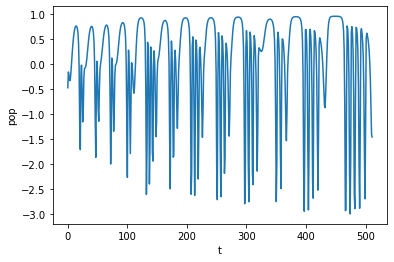

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 185.493
[02] theta: 7.817, delta: 1.100, log Likelihood: 270.265
[03] theta: 7.817, delta: 2.310, log Likelihood: 337.995
[04] theta: 7.817, delta: 3.641, log Likelihood: 384.816
[05] theta: 7.817, delta: 5.105, log Likelihood: 414.263
[06] theta: 7.817, delta: 6.716, log Likelihood: 430.309
[07] theta: 7.817, delta: 8.487, log Likelihood: 435.760
[08] theta: 7.817, delta: 10.436, log Likelihood: 432.569
[09] theta: 7.817, delta: 9.462, log Likelihood: 435.117
[10] theta: 7.817, delta: 8.390, log Likelihood: 435.702
[11] theta: 7.817, delta: 8.926, log Likelihood: 435.734
[12] theta: 7.817, delta: 8.658, log Likelihood: 435.805
[13] theta: 7.817, delta: 8.792, log Likelihood: 435.790
[14] theta: 7.817, delta: 8.725, log Likelihood: 435.803
[15] theta: 7.817, delta: 8.651, log Likelihood: 435.804
0.76 7.817299496875003 8.650985031218758 -435.80437069144705 0.016971597703027752 2 234.76751990183715


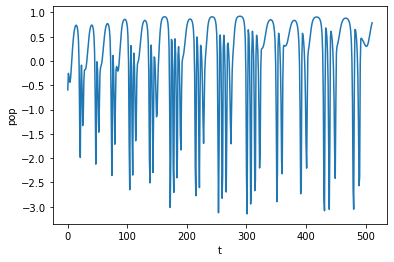

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 293.002
[02] theta: 7.817, delta: 1.100, log Likelihood: 354.476
[03] theta: 7.817, delta: 2.310, log Likelihood: 398.311
[04] theta: 7.817, delta: 3.641, log Likelihood: 426.695
[05] theta: 7.817, delta: 5.105, log Likelihood: 441.079
[06] theta: 7.817, delta: 6.716, log Likelihood: 443.521
[07] theta: 7.817, delta: 5.910, log Likelihood: 443.640
[08] theta: 7.817, delta: 6.313, log Likelihood: 443.868
[09] theta: 7.817, delta: 6.112, log Likelihood: 443.832
[10] theta: 7.817, delta: 6.212, log Likelihood: 443.869
[11] theta: 7.817, delta: 6.323, log Likelihood: 443.866
0.8 7.817299496875003 6.323048187500003 -443.86644092632173 0.009534958144302592 2 209.6348719037561


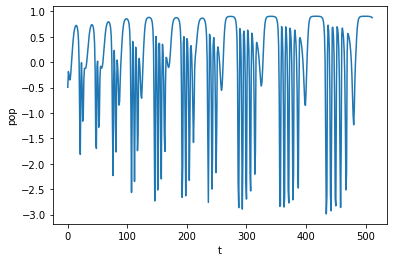

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 153.681
[02] theta: 7.817, delta: 1.100, log Likelihood: 218.773
[03] theta: 7.817, delta: 2.310, log Likelihood: 259.547
[04] theta: 7.817, delta: 3.641, log Likelihood: 274.999
[05] theta: 7.817, delta: 5.105, log Likelihood: 270.868
[06] theta: 7.817, delta: 4.373, log Likelihood: 274.895
[07] theta: 7.817, delta: 3.568, log Likelihood: 274.735
[08] theta: 7.817, delta: 3.970, log Likelihood: 275.531
[09] theta: 7.817, delta: 4.413, log Likelihood: 274.763
[10] theta: 7.817, delta: 4.192, log Likelihood: 275.341
[11] theta: 7.817, delta: 3.948, log Likelihood: 275.527
[12] theta: 7.817, delta: 4.070, log Likelihood: 275.496
[13] theta: 7.817, delta: 4.009, log Likelihood: 275.528
[14] theta: 7.817, delta: 3.942, log Likelihood: 275.525
0.84 7.817299496875003 3.9421882465625013 -275.5248340425267 0.016012202158622216 2 208.4199691785295


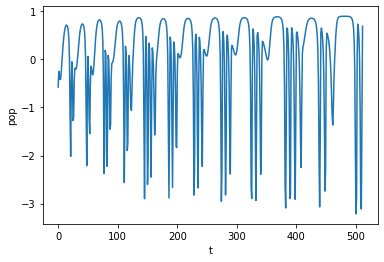

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 48.778
[02] theta: 7.817, delta: 1.100, log Likelihood: 116.980
[03] theta: 7.817, delta: 2.310, log Likelihood: 158.337
[04] theta: 7.817, delta: 3.641, log Likelihood: 173.357
[05] theta: 7.817, delta: 5.105, log Likelihood: 167.209
[06] theta: 7.817, delta: 4.373, log Likelihood: 172.521
[07] theta: 7.817, delta: 3.568, log Likelihood: 173.143
[08] theta: 7.817, delta: 3.970, log Likelihood: 173.616
[09] theta: 7.817, delta: 3.769, log Likelihood: 173.591
[10] theta: 7.817, delta: 3.870, log Likelihood: 173.654
[11] theta: 7.817, delta: 3.980, log Likelihood: 173.607
[12] theta: 7.817, delta: 3.925, log Likelihood: 173.645
[13] theta: 7.817, delta: 3.864, log Likelihood: 173.653
0.88 7.817299496875003 3.8642294968750015 -173.65336131629562 0.01572097563068857 2 198.33095187247292


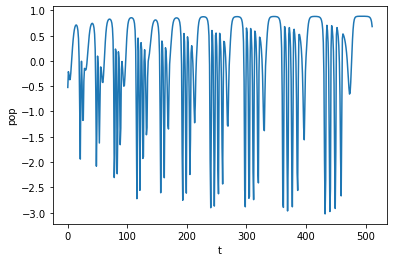

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 220.990
[02] theta: 7.817, delta: 1.100, log Likelihood: 271.440
[03] theta: 7.817, delta: 2.310, log Likelihood: 308.805
[04] theta: 7.817, delta: 3.641, log Likelihood: 332.338
[05] theta: 7.817, delta: 5.105, log Likelihood: 344.148
[06] theta: 7.817, delta: 6.716, log Likelihood: 349.365
[07] theta: 7.817, delta: 8.487, log Likelihood: 351.688
[08] theta: 7.817, delta: 10.436, log Likelihood: 351.783
[09] theta: 7.817, delta: 9.462, log Likelihood: 352.073
[10] theta: 7.817, delta: 9.949, log Likelihood: 352.019
[11] theta: 7.817, delta: 9.705, log Likelihood: 352.068
[12] theta: 7.817, delta: 9.437, log Likelihood: 352.071
0.92 7.817299496875003 9.437170586250007 -352.0712869516538 0.011259611900280311 2 228.1697026472161


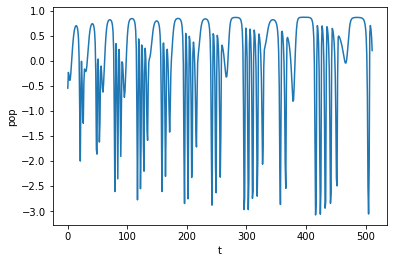

7.817299496875003
[ True False]
[01] theta: 7.817, delta: 0.000, log Likelihood: 71.324
[02] theta: 7.817, delta: 1.100, log Likelihood: 138.468
[03] theta: 7.817, delta: 2.310, log Likelihood: 188.736
[04] theta: 7.817, delta: 3.641, log Likelihood: 218.150
[05] theta: 7.817, delta: 5.105, log Likelihood: 232.168
[06] theta: 7.817, delta: 6.716, log Likelihood: 237.796
[07] theta: 7.817, delta: 8.487, log Likelihood: 238.910
[08] theta: 7.817, delta: 7.601, log Likelihood: 238.824
[09] theta: 7.817, delta: 8.044, log Likelihood: 238.972
[10] theta: 7.817, delta: 8.531, log Likelihood: 238.893
[11] theta: 7.817, delta: 8.288, log Likelihood: 238.963
[12] theta: 7.817, delta: 8.020, log Likelihood: 238.970
0.96 7.817299496875003 8.019921786250004 -238.96966929826073 0.019762822855306693 2 231.51385561401693


In [259]:
data = driverVdelta(25, thetaS, 2, 1)

In [4]:
weightDropoff = np.exp(-data[:,2]*0.25)
# weightDropoff = (1-datums[:,2])**(1/10)
pcc = np.corrcoef(data[:,0],weightDropoff)[0,1]

NameError: name 'data' is not defined

NameError: name 'data' is not defined

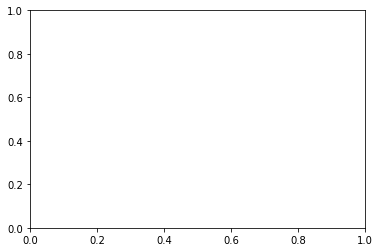

In [5]:
# plotTS((1-datums[:,2])**0.1)
fig, ax = plt.subplots(1)
#ax.plot(datums[:,0], (1-datums[:,2])**0.1)

ax.plot(data[:,0], weightDropoff)
ax.set_ylabel("Drop in weight over 25% of series")
ax.set_xlabel("Rate of nonstationary change")
ax.text(0.65,0.98,f"r={pcc:.3f}")
plt.show()

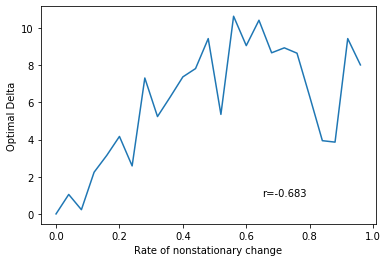

In [277]:
# plotTS((1-datums[:,2])**0.1)
fig, ax = plt.subplots(1)
#ax.plot(datums[:,0], (1-datums[:,2])**0.1)

ax.plot(data[:,0], data[:,2])
ax.set_ylabel("Optimal Delta")
ax.set_xlabel("Rate of nonstationary change")
ax.text(0.65,0.98,f"r={pcc:.3f}")
plt.show()

In [40]:
# fix, ax = plt.subplots(1)
# ax.imshow(landNS[1:,1:,2])

In [41]:
deltaNS

0.0

In [42]:
dynamic_similarity_matrix = schreiberContinuous(Xn, Yn, txn, thetaNS, deltaNS)

KeyboardInterrupt: 

In [ ]:
plt.imshow(np.exp(-dynamic_similarity_matrix))

In [ ]:
driverVdelta = np.array([[0, 0.9939017526504343],
          [0.5, 0.913616621633756],
          [1, 0.9404808557939969],
          [1.5, 0.8986395799598124],
          [2.0, 0.7594675023780507],
          [2.5, 0.7385951709456133],
          [3.0, 0.7735371385558871],
          [3.5, 0.9095528584046055]])

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.plot(driverVdelta[:,0],driverVdelta[:,1])
ax.set_xlabel("Slope of driver")
ax.set_ylabel("Drop in weight over 10% of series length")
ax.text(1.55,0.98,f"r={np.corrcoef(driverVdelta[:,0],driverVdelta[:,1])[0,1]}")

In [ ]:
emb_diff = 1

E1, _ = delayEmbed(Xr, 1, 1, 1)
E2, _ = delayEmbed(Xr, 1, 1+emb_diff, 1)

D1 = distanceMatrix(E1)
D2 = distanceMatrix(E2)

In [ ]:
E1[1+emb_diff:]

In [ ]:
E2[1:]

In [ ]:
fig, ax = plt.subplots(3, figsize=(8,24))
ax[0].imshow(D1)
ax[1].imshow(D2)
ax[2].imshow(D1[emb_diff:,emb_diff:]-D2)

plt.show()

In [291]:
np.argsort(np.array([-8,2,6,-1]))

array([0, 3, 1, 2], dtype=int32)